In [66]:
import optuna
import joblib
import pandas as pd
import numpy as np
import warnings
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import shap

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, KFold, learning_curve
from pathlib import Path

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
DATA_PATH = '../data/FinalTrainingData.parquet'
MODEL_PATH = '../models/lgbm_regressor.pkl'
N_TRIALS = 50
SEED = 999
CATEGORICALS = [
    'DISTRICT_CODE', 'DISTRICT_NAME', 'LOCATION_ID',
    'SCHOOL_NAME', 'STUDENT_ID', 'ETHNIC_CODE', 
    'STUDENT_GENDER', 'ECONOMIC_CODE', 'SPECIAL_ED_CODE',
    'ENG_PROF_CODE', 'HISPANIC_IND'
]
OBJECT_COLS = [
    'Att_Rate_Prev1_2019', 'Att_Rate_Prev2_2019', 'Delta_Attendance_2019', 'Grade_X_Gender_2019', 'Econ_X_Grade_Band_2019', 'Att_Rate_Prev2_2020', 'Grade_X_Gender_2020', 'Econ_X_Grade_Band_2020', 'Grade_X_Gender_2021', 'Econ_X_Grade_Band_2021', 'Grade_X_Gender_2022', 'Econ_X_Grade_Band_2022',
    'Grade_X_Gender_2023', 'Econ_X_Grade_Band_2023'
]
FOLDS = [
    (2021, 2022),
    (2022, 2023), 
    (2023, 2024)
]

YEAR_PATTERN = re.compile(r'_(\d{4})$')

In [5]:
df = pd.read_parquet(DATA_PATH)
for col in CATEGORICALS:
    if col in df.columns:
        df[col] = df[col].astype('category')

for col in OBJECT_COLS:
    if col in df.columns:
        df[col] = df[col].astype('category')

STATIC_FEATURES = [c for c in CATEGORICALS if c in df.columns]

In [6]:
def cols_up_to(year: int) -> list[str]:
    keep = []
    for col in df.columns:
        res = YEAR_PATTERN.search(col)
        if res:
            if int(res.group(1)) <= year:
                keep.append(col)
        elif col in STATIC_FEATURES or col in OBJECT_COLS:
            keep.append(col)

    return keep

In [93]:
# Optuna Hyperparameter Tuning
def objective(trial: optuna.Trial) -> float:
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'randome_state': SEED,
        'verbosity': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'num_leaves': trial.suggest_int('num_leaves', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }

    rmses = []
    for max_feature_year, target_year in FOLDS:
        feature_cols = cols_up_to(max_feature_year)
        y_col = f'Attendance_Rate_{target_year}'

        x_full, y_full = df.loc[:, feature_cols], df.loc[:, y_col]
        x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=SEED)

        model = LGBMRegressor(**params)
        model.fit(
            x_train, y_train,
            categorical_feature=[c for c in STATIC_FEATURES if c in feature_cols],
            eval_set=[(x_test, y_test)],
            eval_metric='rmse',
        )
        preds = model.predict(x_test, num_iteration=model.best_iteration_)
        rmses.append(mean_squared_error(y_test, preds)) #type: ignore

    return float(np.mean(rmses))

In [94]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
print(f'\nBest RMSE: {study.best_value}')
print(f'\nBest Hyper Parameters: {study.best_params}')

[I 2025-06-06 19:10:45,998] A new study created in memory with name: no-name-c6d4ef0b-a91f-4a4e-9a11-aa73e5e9617c
Best trial: 0. Best value: 0.00624653:   2%|▏         | 1/50 [00:13<11:05, 13.59s/it]

[I 2025-06-06 19:10:59,587] Trial 0 finished with value: 0.006246525052779368 and parameters: {'learning_rate': 0.15373071059435936, 'n_estimators': 1079, 'num_leaves': 44, 'max_depth': 11, 'min_child_samples': 13, 'min_child_weight': 0.021325671898157497, 'reg_alpha': 7.021477798505748e-05, 'reg_lambda': 0.0009760505530639855, 'feature_fraction': 0.7768759134865365, 'bagging_fraction': 0.818435766516609, 'bagging_freq': 6, 'min_gain_to_split': 1.9783552934191388, 'lambda_l1': 1.2160013712944446e-05, 'lambda_l2': 6.516831580591641e-07}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:   4%|▍         | 2/50 [00:19<07:04,  8.85s/it]

[I 2025-06-06 19:11:05,119] Trial 1 finished with value: 0.006681390413531126 and parameters: {'learning_rate': 0.11086734675956622, 'n_estimators': 115, 'num_leaves': 274, 'max_depth': 8, 'min_child_samples': 78, 'min_child_weight': 0.07852962128617527, 'reg_alpha': 3.806012947026401e-06, 'reg_lambda': 0.05776069349473615, 'feature_fraction': 0.4582539660608414, 'bagging_fraction': 0.6474146729872345, 'bagging_freq': 2, 'min_gain_to_split': 5.8541667088453835, 'lambda_l1': 0.6918037096270477, 'lambda_l2': 5.3852523055348285e-08}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:   6%|▌         | 3/50 [00:28<07:07,  9.09s/it]

[I 2025-06-06 19:11:14,489] Trial 2 finished with value: 0.007497794581745591 and parameters: {'learning_rate': 0.06670094433426496, 'n_estimators': 1118, 'num_leaves': 106, 'max_depth': 15, 'min_child_samples': 32, 'min_child_weight': 0.1079021242291737, 'reg_alpha': 2.1456388467314036e-07, 'reg_lambda': 5.860111280222689e-07, 'feature_fraction': 0.9044920064414071, 'bagging_fraction': 0.4022519219151519, 'bagging_freq': 6, 'min_gain_to_split': 12.502165753761798, 'lambda_l1': 2.76163352653278, 'lambda_l2': 5.667805903644579}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:   8%|▊         | 4/50 [00:34<06:06,  7.96s/it]

[I 2025-06-06 19:11:20,732] Trial 3 finished with value: 0.006693751498818522 and parameters: {'learning_rate': 0.16989500738117824, 'n_estimators': 178, 'num_leaves': 127, 'max_depth': 7, 'min_child_samples': 53, 'min_child_weight': 8.156575089385031, 'reg_alpha': 0.2349156122301988, 'reg_lambda': 4.873839202424977e-07, 'feature_fraction': 0.8188288716492873, 'bagging_fraction': 0.8095664601364811, 'bagging_freq': 7, 'min_gain_to_split': 7.239467409317802, 'lambda_l1': 0.037612662980922314, 'lambda_l2': 0.1434303994960133}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:  10%|█         | 5/50 [00:42<05:55,  7.90s/it]

[I 2025-06-06 19:11:28,525] Trial 4 finished with value: 0.007089355850681129 and parameters: {'learning_rate': 0.024328044814066904, 'n_estimators': 364, 'num_leaves': 213, 'max_depth': 14, 'min_child_samples': 92, 'min_child_weight': 0.017774445460687578, 'reg_alpha': 3.864874514901747, 'reg_lambda': 0.03298958829361979, 'feature_fraction': 0.41254623219644904, 'bagging_fraction': 0.8353273127137824, 'bagging_freq': 5, 'min_gain_to_split': 14.31853044576321, 'lambda_l1': 0.047971965455157944, 'lambda_l2': 5.991430009110224e-07}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:  12%|█▏        | 6/50 [01:40<18:19, 24.99s/it]

[I 2025-06-06 19:12:26,689] Trial 5 finished with value: 0.006892996203252434 and parameters: {'learning_rate': 0.252230548488619, 'n_estimators': 1724, 'num_leaves': 140, 'max_depth': 13, 'min_child_samples': 100, 'min_child_weight': 0.18051884711048632, 'reg_alpha': 0.0019999280231350804, 'reg_lambda': 6.550027800520155e-05, 'feature_fraction': 0.9372927184926154, 'bagging_fraction': 0.6666235933754334, 'bagging_freq': 5, 'min_gain_to_split': 9.902902875898151, 'lambda_l1': 5.2721456403667715e-06, 'lambda_l2': 1.6092348559086527e-08}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:  14%|█▍        | 7/50 [02:12<19:28, 27.18s/it]

[I 2025-06-06 19:12:58,362] Trial 6 finished with value: 0.00650261333702343 and parameters: {'learning_rate': 0.17271865027491268, 'n_estimators': 673, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 84, 'min_child_weight': 0.005489049525070069, 'reg_alpha': 5.33557818998837, 'reg_lambda': 0.018535763191138074, 'feature_fraction': 0.7633975191746483, 'bagging_fraction': 0.6976039686630994, 'bagging_freq': 5, 'min_gain_to_split': 3.906627906022017, 'lambda_l1': 0.007482969114853584, 'lambda_l2': 0.00404354800827735}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:  16%|█▌        | 8/50 [02:42<19:38, 28.07s/it]

[I 2025-06-06 19:13:28,330] Trial 7 finished with value: 0.00707022285752247 and parameters: {'learning_rate': 0.17179528428007845, 'n_estimators': 746, 'num_leaves': 287, 'max_depth': 3, 'min_child_samples': 88, 'min_child_weight': 0.16065713669296, 'reg_alpha': 1.0145743690638607, 'reg_lambda': 0.05266697256389688, 'feature_fraction': 0.5247011396123056, 'bagging_fraction': 0.692940383934376, 'bagging_freq': 5, 'min_gain_to_split': 13.063094384053286, 'lambda_l1': 0.1561818972781415, 'lambda_l2': 3.8977766744176887}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:  18%|█▊        | 9/50 [03:03<17:45, 25.98s/it]

[I 2025-06-06 19:13:49,724] Trial 8 finished with value: 0.0068699272535071715 and parameters: {'learning_rate': 0.01803278798249844, 'n_estimators': 258, 'num_leaves': 192, 'max_depth': 7, 'min_child_samples': 67, 'min_child_weight': 0.5575567226566616, 'reg_alpha': 0.00019149388380731264, 'reg_lambda': 0.009825009344492066, 'feature_fraction': 0.9721004977026482, 'bagging_fraction': 0.5089268474826673, 'bagging_freq': 5, 'min_gain_to_split': 6.710043961075486, 'lambda_l1': 0.0005256400998902646, 'lambda_l2': 6.779436022456834e-08}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 0. Best value: 0.00624653:  20%|██        | 10/50 [03:53<22:19, 33.48s/it]

[I 2025-06-06 19:14:39,984] Trial 9 finished with value: 0.007171660686428279 and parameters: {'learning_rate': 0.0983524684007343, 'n_estimators': 1832, 'num_leaves': 106, 'max_depth': 15, 'min_child_samples': 21, 'min_child_weight': 0.0016738637807675028, 'reg_alpha': 3.523239128004447e-08, 'reg_lambda': 0.10435261925967494, 'feature_fraction': 0.7388809691539069, 'bagging_fraction': 0.481267911820885, 'bagging_freq': 4, 'min_gain_to_split': 9.85323632977334, 'lambda_l1': 2.5535100763427456, 'lambda_l2': 0.0007728862095003443}. Best is trial 0 with value: 0.006246525052779368.


Best trial: 10. Best value: 0.00584803:  22%|██▏       | 11/50 [05:06<29:28, 45.35s/it]

[I 2025-06-06 19:15:52,250] Trial 10 finished with value: 0.0058480261519213705 and parameters: {'learning_rate': 0.036358955357189526, 'n_estimators': 1291, 'num_leaves': 19, 'max_depth': 11, 'min_child_samples': 5, 'min_child_weight': 1.9401871688010077, 'reg_alpha': 0.0003922146602080417, 'reg_lambda': 9.561915887775573, 'feature_fraction': 0.5956410379193441, 'bagging_fraction': 0.9979687564938668, 'bagging_freq': 1, 'min_gain_to_split': 0.10608126324371625, 'lambda_l1': 2.031514296534441e-08, 'lambda_l2': 6.415201787309339e-06}. Best is trial 10 with value: 0.0058480261519213705.


Best trial: 11. Best value: 0.00580549:  24%|██▍       | 12/50 [06:27<35:41, 56.36s/it]

[I 2025-06-06 19:17:13,786] Trial 11 finished with value: 0.005805490633084782 and parameters: {'learning_rate': 0.03510491605364247, 'n_estimators': 1289, 'num_leaves': 12, 'max_depth': 11, 'min_child_samples': 6, 'min_child_weight': 3.4428826844697205, 'reg_alpha': 0.0003408814784196783, 'reg_lambda': 7.314335106163106, 'feature_fraction': 0.6184893348672729, 'bagging_fraction': 0.9918960981894813, 'bagging_freq': 1, 'min_gain_to_split': 0.04092692198381144, 'lambda_l1': 8.895637423905227e-08, 'lambda_l2': 7.3100005965829225e-06}. Best is trial 11 with value: 0.005805490633084782.


Best trial: 12. Best value: 0.00571891:  26%|██▌       | 13/50 [08:25<46:17, 75.07s/it]

[I 2025-06-06 19:19:11,928] Trial 12 finished with value: 0.005718913501970226 and parameters: {'learning_rate': 0.03187793347826908, 'n_estimators': 1416, 'num_leaves': 15, 'max_depth': 11, 'min_child_samples': 9, 'min_child_weight': 5.0989767957043455, 'reg_alpha': 0.0065283875392360136, 'reg_lambda': 1.1449128977564993, 'feature_fraction': 0.6019754679595203, 'bagging_fraction': 0.974121394316118, 'bagging_freq': 1, 'min_gain_to_split': 0.003244787478175533, 'lambda_l1': 1.492591506646833e-08, 'lambda_l2': 1.9818051331341124e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  28%|██▊       | 14/50 [09:54<47:31, 79.21s/it]

[I 2025-06-06 19:20:40,684] Trial 13 finished with value: 0.00598454616704127 and parameters: {'learning_rate': 0.01225133844014888, 'n_estimators': 1519, 'num_leaves': 58, 'max_depth': 11, 'min_child_samples': 37, 'min_child_weight': 8.402107316802168, 'reg_alpha': 0.007585715749293206, 'reg_lambda': 5.259307312022878, 'feature_fraction': 0.6292730291179458, 'bagging_fraction': 0.9840457270696654, 'bagging_freq': 2, 'min_gain_to_split': 0.6682781571570011, 'lambda_l1': 1.4502066818729375e-08, 'lambda_l2': 2.4988958703349413e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  30%|███       | 15/50 [11:01<43:57, 75.37s/it]

[I 2025-06-06 19:21:47,156] Trial 14 finished with value: 0.006373077399204223 and parameters: {'learning_rate': 0.04278677267209819, 'n_estimators': 1462, 'num_leaves': 10, 'max_depth': 10, 'min_child_samples': 29, 'min_child_weight': 1.678366338664649, 'reg_alpha': 0.014603367533413793, 'reg_lambda': 1.009675550514042, 'feature_fraction': 0.6501181285983489, 'bagging_fraction': 0.9095532476355045, 'bagging_freq': 1, 'min_gain_to_split': 3.5646886098621464, 'lambda_l1': 3.913530623604352e-07, 'lambda_l2': 5.5142013232406614e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  32%|███▏      | 16/50 [12:18<42:57, 75.81s/it]

[I 2025-06-06 19:23:03,998] Trial 15 finished with value: 0.006304335688963378 and parameters: {'learning_rate': 0.029900078435207672, 'n_estimators': 1962, 'num_leaves': 69, 'max_depth': 13, 'min_child_samples': 47, 'min_child_weight': 2.3108974575293018, 'reg_alpha': 1.1114394737644185e-05, 'reg_lambda': 2.3092051927820457e-05, 'feature_fraction': 0.5449571838047831, 'bagging_fraction': 0.9106579642328453, 'bagging_freq': 3, 'min_gain_to_split': 2.774091269359273, 'lambda_l1': 4.2291287078258046e-07, 'lambda_l2': 0.004014336370576763}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  34%|███▍      | 17/50 [12:57<35:40, 64.86s/it]

[I 2025-06-06 19:23:43,391] Trial 16 finished with value: 0.006497726360977232 and parameters: {'learning_rate': 0.06042275622910049, 'n_estimators': 771, 'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 5, 'min_child_weight': 0.6808427020038171, 'reg_alpha': 0.07517443573793028, 'reg_lambda': 0.5291926042238246, 'feature_fraction': 0.679516595094485, 'bagging_fraction': 0.8813711650530793, 'bagging_freq': 2, 'min_gain_to_split': 5.018703178883653, 'lambda_l1': 2.7922503868028127e-07, 'lambda_l2': 4.072961807251706e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  36%|███▌      | 18/50 [14:10<35:55, 67.37s/it]

[I 2025-06-06 19:24:56,595] Trial 17 finished with value: 0.006147023664040056 and parameters: {'learning_rate': 0.018008977526184595, 'n_estimators': 1549, 'num_leaves': 192, 'max_depth': 12, 'min_child_samples': 19, 'min_child_weight': 9.94441660864243, 'reg_alpha': 2.323213140019888e-06, 'reg_lambda': 0.0014669779128790583, 'feature_fraction': 0.5535232091990949, 'bagging_fraction': 0.9453292661847111, 'bagging_freq': 1, 'min_gain_to_split': 1.6176919129517158, 'lambda_l1': 2.470248585891791e-05, 'lambda_l2': 0.0002009342473503563}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  38%|███▊      | 19/50 [15:38<37:55, 73.40s/it]

[I 2025-06-06 19:26:24,037] Trial 18 finished with value: 0.005859014638484993 and parameters: {'learning_rate': 0.010664641425546018, 'n_estimators': 1317, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 48, 'min_child_weight': 0.6172448705669459, 'reg_alpha': 0.001456939381387405, 'reg_lambda': 1.1996690923783945e-08, 'feature_fraction': 0.49161995362918204, 'bagging_fraction': 0.7960825011893045, 'bagging_freq': 3, 'min_gain_to_split': 0.18231214920900818, 'lambda_l1': 4.855738115128563e-08, 'lambda_l2': 6.670641950080786e-07}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  40%|████      | 20/50 [16:26<33:01, 66.05s/it]

[I 2025-06-06 19:27:12,970] Trial 19 finished with value: 0.006839341407618845 and parameters: {'learning_rate': 0.04308012671155094, 'n_estimators': 1245, 'num_leaves': 74, 'max_depth': 13, 'min_child_samples': 16, 'min_child_weight': 3.3471277545175124, 'reg_alpha': 3.2626833757528705e-05, 'reg_lambda': 1.3654078115428394, 'feature_fraction': 0.5980745776858662, 'bagging_fraction': 0.759880724078582, 'bagging_freq': 3, 'min_gain_to_split': 9.157568638521207, 'lambda_l1': 0.00025754801883886907, 'lambda_l2': 0.016844198210471402}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  42%|████▏     | 21/50 [17:04<27:51, 57.63s/it]

[I 2025-06-06 19:27:50,952] Trial 20 finished with value: 0.006577432553484885 and parameters: {'learning_rate': 0.021407407023731253, 'n_estimators': 816, 'num_leaves': 248, 'max_depth': 6, 'min_child_samples': 63, 'min_child_weight': 0.38185841235913004, 'reg_alpha': 0.02757180253410313, 'reg_lambda': 0.3035567473100095, 'feature_fraction': 0.8344922850008263, 'bagging_fraction': 0.6158734676010937, 'bagging_freq': 2, 'min_gain_to_split': 4.555726041680488, 'lambda_l1': 2.6783543697555725e-06, 'lambda_l2': 0.00020531477791982362}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  44%|████▍     | 22/50 [18:15<28:40, 61.44s/it]

[I 2025-06-06 19:29:01,294] Trial 21 finished with value: 0.005984326617300304 and parameters: {'learning_rate': 0.03494556323737576, 'n_estimators': 1363, 'num_leaves': 11, 'max_depth': 11, 'min_child_samples': 7, 'min_child_weight': 3.374404355259597, 'reg_alpha': 0.0007316302165039646, 'reg_lambda': 6.4692906152929135, 'feature_fraction': 0.6033738236849634, 'bagging_fraction': 0.9961627414482445, 'bagging_freq': 1, 'min_gain_to_split': 0.2995237564984201, 'lambda_l1': 1.2888787201842373e-08, 'lambda_l2': 6.449537838432842e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  46%|████▌     | 23/50 [19:09<26:38, 59.22s/it]

[I 2025-06-06 19:29:55,335] Trial 22 finished with value: 0.006154588064108253 and parameters: {'learning_rate': 0.047465297892253226, 'n_estimators': 992, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 27, 'min_child_weight': 1.3631880658396751, 'reg_alpha': 0.0003960092496518007, 'reg_lambda': 8.189091968215555, 'feature_fraction': 0.6676938094312141, 'bagging_fraction': 0.9980135693600197, 'bagging_freq': 1, 'min_gain_to_split': 1.6816592118669307, 'lambda_l1': 1.0408554606475664e-07, 'lambda_l2': 5.3061899788096135e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  48%|████▊     | 24/50 [20:30<28:31, 65.84s/it]

[I 2025-06-06 19:31:16,624] Trial 23 finished with value: 0.006290780475808294 and parameters: {'learning_rate': 0.030998761096850718, 'n_estimators': 1675, 'num_leaves': 10, 'max_depth': 10, 'min_child_samples': 5, 'min_child_weight': 4.168030688268054, 'reg_alpha': 0.00013734151021312576, 'reg_lambda': 1.7301998508729715, 'feature_fraction': 0.7039697206383083, 'bagging_fraction': 0.9367710944228597, 'bagging_freq': 1, 'min_gain_to_split': 2.6248900029637565, 'lambda_l1': 1.0135469209567204e-08, 'lambda_l2': 3.559359432644336e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  50%|█████     | 25/50 [22:11<31:46, 76.28s/it]

[I 2025-06-06 19:32:57,248] Trial 24 finished with value: 0.005754364482167499 and parameters: {'learning_rate': 0.07021385246397281, 'n_estimators': 1229, 'num_leaves': 96, 'max_depth': 10, 'min_child_samples': 13, 'min_child_weight': 1.1662861077845936, 'reg_alpha': 0.0032973093751668538, 'reg_lambda': 0.34870803604715855, 'feature_fraction': 0.5781308524526739, 'bagging_fraction': 0.878507885781491, 'bagging_freq': 2, 'min_gain_to_split': 0.021581639230617525, 'lambda_l1': 8.291963668164008e-07, 'lambda_l2': 2.025037249097048e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  52%|█████▏    | 26/50 [22:54<26:34, 66.46s/it]

[I 2025-06-06 19:33:40,795] Trial 25 finished with value: 0.006153321144208951 and parameters: {'learning_rate': 0.07154894291508979, 'n_estimators': 1000, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 39, 'min_child_weight': 0.959043524229404, 'reg_alpha': 0.0027711228060758354, 'reg_lambda': 0.0043793343780425134, 'feature_fraction': 0.47886848709313157, 'bagging_fraction': 0.8689548356232786, 'bagging_freq': 2, 'min_gain_to_split': 1.3652291439707802, 'lambda_l1': 1.6300930880194263e-06, 'lambda_l2': 7.908818296838433e-07}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  54%|█████▍    | 27/50 [23:39<23:01, 60.07s/it]

[I 2025-06-06 19:34:25,944] Trial 26 finished with value: 0.006315039372382425 and parameters: {'learning_rate': 0.09497650142903934, 'n_estimators': 1159, 'num_leaves': 163, 'max_depth': 8, 'min_child_samples': 13, 'min_child_weight': 0.32012944326921955, 'reg_alpha': 0.15915781211482413, 'reg_lambda': 0.24718398959881227, 'feature_fraction': 0.5864443967788446, 'bagging_fraction': 0.946902531766238, 'bagging_freq': 3, 'min_gain_to_split': 3.0184210780129734, 'lambda_l1': 4.643919165136326e-05, 'lambda_l2': 0.0007644816476087142}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  56%|█████▌    | 28/50 [24:19<19:48, 54.02s/it]

[I 2025-06-06 19:35:05,848] Trial 27 finished with value: 0.006128421001285151 and parameters: {'learning_rate': 0.07922437180694653, 'n_estimators': 1655, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 26, 'min_child_weight': 4.6867596049649185, 'reg_alpha': 0.005930890960690447, 'reg_lambda': 0.00016353282750087078, 'feature_fraction': 0.7165691810314904, 'bagging_fraction': 0.748949412128441, 'bagging_freq': 2, 'min_gain_to_split': 1.1667826005696011, 'lambda_l1': 1.2476319190923438e-07, 'lambda_l2': 1.2210886075760998e-07}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  58%|█████▊    | 29/50 [24:49<16:21, 46.74s/it]

[I 2025-06-06 19:35:35,604] Trial 28 finished with value: 0.006285289806186565 and parameters: {'learning_rate': 0.053192583049468715, 'n_estimators': 923, 'num_leaves': 90, 'max_depth': 12, 'min_child_samples': 21, 'min_child_weight': 1.1064023074201723, 'reg_alpha': 0.04267088794364269, 'reg_lambda': 0.2221579292358099, 'feature_fraction': 0.4075432881834826, 'bagging_fraction': 0.8721311274360213, 'bagging_freq': 4, 'min_gain_to_split': 2.31061983088899, 'lambda_l1': 1.0323895766084745e-06, 'lambda_l2': 2.293694549545677e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  60%|██████    | 30/50 [25:25<14:30, 43.55s/it]

[I 2025-06-06 19:36:11,712] Trial 29 finished with value: 0.006467075883766118 and parameters: {'learning_rate': 0.025433068704198442, 'n_estimators': 610, 'num_leaves': 39, 'max_depth': 11, 'min_child_samples': 12, 'min_child_weight': 0.020421285912935582, 'reg_alpha': 0.4696532412810201, 'reg_lambda': 0.0014291600783403182, 'feature_fraction': 0.5173522843493559, 'bagging_fraction': 0.9483494637316632, 'bagging_freq': 1, 'min_gain_to_split': 4.883377954274634, 'lambda_l1': 7.944832582951081e-06, 'lambda_l2': 1.718137815753528e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  62%|██████▏   | 31/50 [26:12<14:03, 44.40s/it]

[I 2025-06-06 19:36:58,112] Trial 30 finished with value: 0.0067007556003555084 and parameters: {'learning_rate': 0.12548911983593417, 'n_estimators': 1434, 'num_leaves': 161, 'max_depth': 10, 'min_child_samples': 11, 'min_child_weight': 0.05510068514509743, 'reg_alpha': 5.73809224141996e-05, 'reg_lambda': 1.5918174622320234, 'feature_fraction': 0.640524865656359, 'bagging_fraction': 0.8452820600310549, 'bagging_freq': 2, 'min_gain_to_split': 8.084404875412098, 'lambda_l1': 6.022103904126563e-08, 'lambda_l2': 3.173182847473895e-07}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  64%|██████▍   | 32/50 [27:21<15:32, 51.82s/it]

[I 2025-06-06 19:38:07,220] Trial 31 finished with value: 0.005725334382501287 and parameters: {'learning_rate': 0.03688773031875274, 'n_estimators': 1226, 'num_leaves': 26, 'max_depth': 12, 'min_child_samples': 13, 'min_child_weight': 2.090395583543616, 'reg_alpha': 0.0005444713541769827, 'reg_lambda': 8.344871171418397, 'feature_fraction': 0.5622396239886531, 'bagging_fraction': 0.9610725644032474, 'bagging_freq': 1, 'min_gain_to_split': 0.019585659956634367, 'lambda_l1': 3.723715967176115e-08, 'lambda_l2': 7.579475922998138e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  66%|██████▌   | 33/50 [27:56<13:16, 46.88s/it]

[I 2025-06-06 19:38:42,569] Trial 32 finished with value: 0.0060621888588615865 and parameters: {'learning_rate': 0.03941853323390397, 'n_estimators': 1207, 'num_leaves': 26, 'max_depth': 12, 'min_child_samples': 17, 'min_child_weight': 5.745443840845897, 'reg_alpha': 2.2262378174337116e-05, 'reg_lambda': 2.41364586806759, 'feature_fraction': 0.5663428892821036, 'bagging_fraction': 0.9066753847103027, 'bagging_freq': 1, 'min_gain_to_split': 0.9707373824908436, 'lambda_l1': 4.9803040651286186e-08, 'lambda_l2': 5.06824421376266e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  68%|██████▊   | 34/50 [28:24<11:00, 41.26s/it]

[I 2025-06-06 19:39:10,710] Trial 33 finished with value: 0.0062138648000537805 and parameters: {'learning_rate': 0.055898927111263375, 'n_estimators': 1091, 'num_leaves': 47, 'max_depth': 14, 'min_child_samples': 35, 'min_child_weight': 2.5346823179615763, 'reg_alpha': 5.648880772941183e-06, 'reg_lambda': 0.5355284305514119, 'feature_fraction': 0.4461543565415947, 'bagging_fraction': 0.9599531859362402, 'bagging_freq': 2, 'min_gain_to_split': 1.92396894418436, 'lambda_l1': 4.567159613987243e-07, 'lambda_l2': 1.9325286490471274e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  70%|███████   | 35/50 [29:27<11:56, 47.74s/it]

[I 2025-06-06 19:40:13,577] Trial 34 finished with value: 0.005801076036002419 and parameters: {'learning_rate': 0.01609933844103952, 'n_estimators': 1409, 'num_leaves': 60, 'max_depth': 14, 'min_child_samples': 25, 'min_child_weight': 4.831024928342822, 'reg_alpha': 1.4572692190687637e-06, 'reg_lambda': 0.08757996502540547, 'feature_fraction': 0.6279582572258775, 'bagging_fraction': 0.9148651262979031, 'bagging_freq': 1, 'min_gain_to_split': 0.1248940707210826, 'lambda_l1': 1.6665146587660993e-07, 'lambda_l2': 1.7472532042261123e-07}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  72%|███████▏  | 36/50 [30:12<10:56, 46.87s/it]

[I 2025-06-06 19:40:58,406] Trial 35 finished with value: 0.006068653396058184 and parameters: {'learning_rate': 0.014198249592288955, 'n_estimators': 1398, 'num_leaves': 88, 'max_depth': 14, 'min_child_samples': 23, 'min_child_weight': 5.640124491369172, 'reg_alpha': 9.417496252886962e-07, 'reg_lambda': 0.11339297618010176, 'feature_fraction': 0.5118852596716945, 'bagging_fraction': 0.8977231982543462, 'bagging_freq': 7, 'min_gain_to_split': 1.0179683931051315, 'lambda_l1': 7.901524088207423e-05, 'lambda_l2': 1.5536535285179538e-07}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  74%|███████▍  | 37/50 [31:10<10:54, 50.38s/it]

[I 2025-06-06 19:41:56,997] Trial 36 finished with value: 0.006415246701580637 and parameters: {'learning_rate': 0.018406899738753122, 'n_estimators': 1602, 'num_leaves': 61, 'max_depth': 15, 'min_child_samples': 13, 'min_child_weight': 1.1640476601467313, 'reg_alpha': 2.0154146411722784e-08, 'reg_lambda': 0.005465341019404933, 'feature_fraction': 0.5630110978680112, 'bagging_fraction': 0.7827093368364572, 'bagging_freq': 2, 'min_gain_to_split': 3.41419151788104, 'lambda_l1': 1.0491448838843015e-06, 'lambda_l2': 2.4806090013374282e-08}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  76%|███████▌  | 38/50 [32:24<11:28, 57.35s/it]

[I 2025-06-06 19:43:10,603] Trial 37 finished with value: 0.006566850372024172 and parameters: {'learning_rate': 0.014086796336342092, 'n_estimators': 1775, 'num_leaves': 107, 'max_depth': 13, 'min_child_samples': 42, 'min_child_weight': 0.2994352784629069, 'reg_alpha': 9.257147138030485e-08, 'reg_lambda': 0.031704641103276025, 'feature_fraction': 0.6785270767725182, 'bagging_fraction': 0.8409908634716003, 'bagging_freq': 1, 'min_gain_to_split': 6.043823792318818, 'lambda_l1': 2.2901936939056042e-07, 'lambda_l2': 2.2347040960266863e-07}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  78%|███████▊  | 39/50 [33:16<10:11, 55.61s/it]

[I 2025-06-06 19:44:02,163] Trial 38 finished with value: 0.006290049841067315 and parameters: {'learning_rate': 0.023357921008972757, 'n_estimators': 1105, 'num_leaves': 32, 'max_depth': 14, 'min_child_samples': 32, 'min_child_weight': 5.831403020808075, 'reg_alpha': 6.622596519408754e-07, 'reg_lambda': 1.0767245246789604e-05, 'feature_fraction': 0.8073241461053086, 'bagging_fraction': 0.7379329854341651, 'bagging_freq': 6, 'min_gain_to_split': 2.2506811499252746, 'lambda_l1': 0.002809455565711193, 'lambda_l2': 1.4777898330347914e-08}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  80%|████████  | 40/50 [33:54<08:25, 50.54s/it]

[I 2025-06-06 19:44:40,869] Trial 39 finished with value: 0.006864415827221855 and parameters: {'learning_rate': 0.028852454240525443, 'n_estimators': 885, 'num_leaves': 136, 'max_depth': 8, 'min_child_samples': 57, 'min_child_weight': 0.06747034514416671, 'reg_alpha': 0.004733829742082232, 'reg_lambda': 0.12703480640606082, 'feature_fraction': 0.45338371923147885, 'bagging_fraction': 0.9263472341274264, 'bagging_freq': 3, 'min_gain_to_split': 11.357601210670907, 'lambda_l1': 3.109716708278148e-08, 'lambda_l2': 1.5004084449767059e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  82%|████████▏ | 41/50 [34:39<07:18, 48.68s/it]

[I 2025-06-06 19:45:25,199] Trial 40 finished with value: 0.006574733368571453 and parameters: {'learning_rate': 0.22794803626466167, 'n_estimators': 1492, 'num_leaves': 80, 'max_depth': 12, 'min_child_samples': 77, 'min_child_weight': 0.04137089448378358, 'reg_alpha': 0.00010230481356020781, 'reg_lambda': 0.015957068501529222, 'feature_fraction': 0.8723612384607626, 'bagging_fraction': 0.5933184887720511, 'bagging_freq': 2, 'min_gain_to_split': 4.289756679050797, 'lambda_l1': 4.61543956823575e-06, 'lambda_l2': 5.2252356813029535e-08}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  84%|████████▍ | 42/50 [36:08<08:06, 60.78s/it]

[I 2025-06-06 19:46:54,224] Trial 41 finished with value: 0.005793704951399178 and parameters: {'learning_rate': 0.04924227529809932, 'n_estimators': 1210, 'num_leaves': 25, 'max_depth': 11, 'min_child_samples': 9, 'min_child_weight': 2.45058462514729, 'reg_alpha': 0.0009845567956525776, 'reg_lambda': 2.977894122973525, 'feature_fraction': 0.6319281080740381, 'bagging_fraction': 0.9726546431648629, 'bagging_freq': 1, 'min_gain_to_split': 0.06432324333613341, 'lambda_l1': 1.2593372772786318e-07, 'lambda_l2': 1.2977214964386514e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  86%|████████▌ | 43/50 [37:18<07:25, 63.67s/it]

[I 2025-06-06 19:48:04,624] Trial 42 finished with value: 0.005968522592932599 and parameters: {'learning_rate': 0.05125226135912585, 'n_estimators': 1190, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 11, 'min_child_weight': 2.182514180588431, 'reg_alpha': 0.0013052193044857919, 'reg_lambda': 0.8810496646299568, 'feature_fraction': 0.6448308153957589, 'bagging_fraction': 0.956770285001524, 'bagging_freq': 1, 'min_gain_to_split': 0.5834585380921412, 'lambda_l1': 1.5039990524830506e-07, 'lambda_l2': 1.4819281340461746e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  88%|████████▊ | 44/50 [38:27<06:31, 65.19s/it]

[I 2025-06-06 19:49:13,383] Trial 43 finished with value: 0.006080054737625379 and parameters: {'learning_rate': 0.07797398826985903, 'n_estimators': 1343, 'num_leaves': 33, 'max_depth': 13, 'min_child_samples': 17, 'min_child_weight': 0.009912269872889654, 'reg_alpha': 0.0008737616472444754, 'reg_lambda': 2.93075076364316, 'feature_fraction': 0.7378351110915853, 'bagging_fraction': 0.8677397052122415, 'bagging_freq': 1, 'min_gain_to_split': 1.083084672452976, 'lambda_l1': 3.0831151839794626e-08, 'lambda_l2': 0.00011902396921171905}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  90%|█████████ | 45/50 [39:21<05:09, 61.81s/it]

[I 2025-06-06 19:50:07,287] Trial 44 finished with value: 0.0062660204046122644 and parameters: {'learning_rate': 0.0645295075307805, 'n_estimators': 1045, 'num_leaves': 26, 'max_depth': 3, 'min_child_samples': 23, 'min_child_weight': 0.8424478275188558, 'reg_alpha': 0.012616799385090948, 'reg_lambda': 0.07778094966558982, 'feature_fraction': 0.5781568412775289, 'bagging_fraction': 0.9707031880791064, 'bagging_freq': 1, 'min_gain_to_split': 1.7796470702634155, 'lambda_l1': 2.9432528801332245e-08, 'lambda_l2': 0.9553427847064561}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  92%|█████████▏| 46/50 [39:57<03:36, 54.20s/it]

[I 2025-06-06 19:50:43,744] Trial 45 finished with value: 0.005811708805425961 and parameters: {'learning_rate': 0.04582142640039426, 'n_estimators': 475, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 10, 'min_child_weight': 6.677028518909499, 'reg_alpha': 0.0023080682414791773, 'reg_lambda': 0.4143059624085174, 'feature_fraction': 0.5432706202406606, 'bagging_fraction': 0.8182703244262555, 'bagging_freq': 2, 'min_gain_to_split': 0.12923105443410618, 'lambda_l1': 1.6707891463178861e-06, 'lambda_l2': 1.2775062157997854e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  94%|█████████▍| 47/50 [40:08<02:03, 41.23s/it]

[I 2025-06-06 19:50:54,713] Trial 46 finished with value: 0.006028305879893972 and parameters: {'learning_rate': 0.1345855070420059, 'n_estimators': 59, 'num_leaves': 108, 'max_depth': 14, 'min_child_samples': 17, 'min_child_weight': 0.1541847426895685, 'reg_alpha': 1.8865785897606127, 'reg_lambda': 0.03460677691854291, 'feature_fraction': 0.624938637881236, 'bagging_fraction': 0.9226117180043777, 'bagging_freq': 1, 'min_gain_to_split': 0.7548574424122922, 'lambda_l1': 5.852289977737723e-07, 'lambda_l2': 5.304871924260908e-07}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  96%|█████████▌| 48/50 [41:12<01:36, 48.10s/it]

[I 2025-06-06 19:51:58,852] Trial 47 finished with value: 0.0063257194363402726 and parameters: {'learning_rate': 0.08430604335131794, 'n_estimators': 1243, 'num_leaves': 25, 'max_depth': 11, 'min_child_samples': 31, 'min_child_weight': 1.5997084937956134, 'reg_alpha': 0.00024520472722203276, 'reg_lambda': 3.342994251494737, 'feature_fraction': 0.608676825012145, 'bagging_fraction': 0.9734504618933622, 'bagging_freq': 6, 'min_gain_to_split': 3.0018967823192946, 'lambda_l1': 1.4780108777982124e-07, 'lambda_l2': 1.9091074216763577e-06}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891:  98%|█████████▊| 49/50 [43:02<01:06, 66.42s/it]

[I 2025-06-06 19:53:48,010] Trial 48 finished with value: 0.005794540933851574 and parameters: {'learning_rate': 0.026513083674087338, 'n_estimators': 1559, 'num_leaves': 119, 'max_depth': 15, 'min_child_samples': 9, 'min_child_weight': 2.7209492717316848, 'reg_alpha': 0.12400611110458828, 'reg_lambda': 2.078188319736683e-06, 'feature_fraction': 0.657924985926996, 'bagging_fraction': 0.8907223747654229, 'bagging_freq': 1, 'min_gain_to_split': 0.11784866849473072, 'lambda_l1': 1.8251128154887132e-05, 'lambda_l2': 9.603971308774499e-05}. Best is trial 12 with value: 0.005718913501970226.


Best trial: 12. Best value: 0.00571891: 100%|██████████| 50/50 [44:38<00:00, 53.57s/it]

[I 2025-06-06 19:55:24,557] Trial 49 finished with value: 0.006204809117435803 and parameters: {'learning_rate': 0.028181155569310886, 'n_estimators': 1833, 'num_leaves': 119, 'max_depth': 8, 'min_child_samples': 9, 'min_child_weight': 0.0019761825470037036, 'reg_alpha': 0.16021441030804406, 'reg_lambda': 4.838718588017718e-07, 'feature_fraction': 0.6679868663721523, 'bagging_fraction': 0.8453281080857056, 'bagging_freq': 2, 'min_gain_to_split': 1.8830353349004003, 'lambda_l1': 1.727408864932214e-05, 'lambda_l2': 0.0018140103487993132}. Best is trial 12 with value: 0.005718913501970226.

Best RMSE: 0.005718913501970226

Best Hyper Parameters: {'learning_rate': 0.03187793347826908, 'n_estimators': 1416, 'num_leaves': 15, 'max_depth': 11, 'min_child_samples': 9, 'min_child_weight': 5.0989767957043455, 'reg_alpha': 0.0065283875392360136, 'reg_lambda': 1.1449128977564993, 'feature_fraction': 0.6019754679595203, 'bagging_fraction': 0.974121394316118, 'bagging_freq': 1, 'min_gain_to_split': 

In [29]:
study_best_params = {
    'learning_rate': 0.03187793347826908, 
    'n_estimators': 1416, 
    'num_leaves': 15, 
    'max_depth': 11, 
    'min_child_samples': 9, 
    'min_child_weight': 5.0989767957043455, 
    'reg_alpha': 0.0065283875392360136, 
    'reg_lambda': 1.1449128977564993, 
    'feature_fraction': 0.6019754679595203, 
    'bagging_fraction': 0.974121394316118, 
    'bagging_freq': 1, 
    'min_gain_to_split': 0.003244787478175533, 
    'lambda_l1': 1.492591506646833e-08, 
    'lambda_l2': 1.9818051331341124e-05
}

best_params = {
    **study_best_params,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'random_state': SEED
}

final_feature_cols = cols_up_to(2023)
final_target = 'Attendance_Rate_2024'

X_train, X_test, y_train, y_test = train_test_split(df[final_feature_cols], df[final_target], test_size=0.2, random_state=SEED)


final_model = LGBMRegressor(**best_params)
final_model.fit(
    X_train,
    y_train,
    categorical_feature= [c for c in STATIC_FEATURES if c in final_feature_cols]
)


[LightGBM] [Warning] feature_fraction is set=0.6019754679595203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019754679595203
[LightGBM] [Warning] min_gain_to_split is set=0.003244787478175533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003244787478175533
[LightGBM] [Warning] lambda_l1 is set=1.492591506646833e-08, reg_alpha=0.0065283875392360136 will be ignored. Current value: lambda_l1=1.492591506646833e-08
[LightGBM] [Warning] lambda_l2 is set=1.9818051331341124e-05, reg_lambda=1.1449128977564993 will be ignored. Current value: lambda_l2=1.9818051331341124e-05
[LightGBM] [Warning] bagging_fraction is set=0.974121394316118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.974121394316118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warnin

,boosting_type,'gbdt'
,num_leaves,15
,max_depth,11
,learning_rate,0.03187793347826908
,n_estimators,1416
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,5.0989767957043455
,min_child_samples,9


In [44]:
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration_)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred) # type:ignore

mask = y_test != 0
mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) #type:ignore

print(f"Root Mean Squared Error: {math.sqrt(mse)}")
print(f"Mean Absolute Percentage Error: {mape}")

[LightGBM] [Warning] feature_fraction is set=0.6019754679595203, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6019754679595203
[LightGBM] [Warning] min_gain_to_split is set=0.003244787478175533, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003244787478175533
[LightGBM] [Warning] lambda_l1 is set=1.492591506646833e-08, reg_alpha=0.0065283875392360136 will be ignored. Current value: lambda_l1=1.492591506646833e-08
[LightGBM] [Warning] lambda_l2 is set=1.9818051331341124e-05, reg_lambda=1.1449128977564993 will be ignored. Current value: lambda_l2=1.9818051331341124e-05
[LightGBM] [Warning] bagging_fraction is set=0.974121394316118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.974121394316118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Root Mean Squared Error: 0.06168785282255905
Mean Absolute Percentage Error: 0.04894265514425514


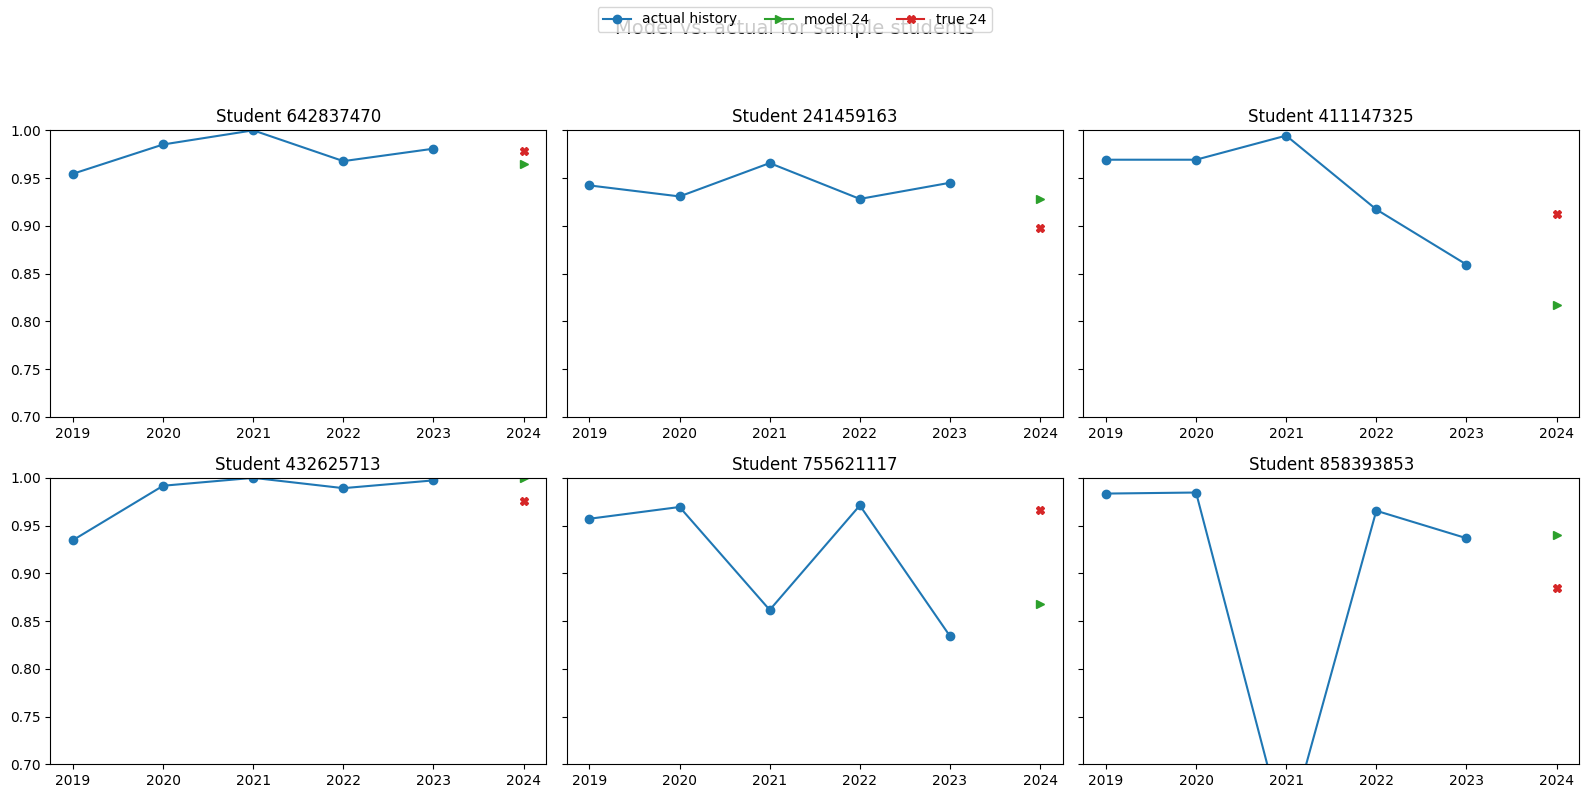

In [ ]:
# Testing
df_test = X_test.copy()
df_test["y_true"] = y_test.values
df_test["y_pred"] = y_pred


n_students = 6
sample_ids = np.random.choice(df_test["STUDENT_ID"].unique(), n_students, replace=False)

attendance_cols = [f"Attendance_Rate_{yr}" for yr in range(2019, 2024)] 
years = np.arange(2019, 2025)                                   

fig, axs = plt.subplots(2, 3, figsize=(16, 8), sharey=True)
axs = axs.ravel()

for ax, sid in zip(axs, sample_ids):
    row  = df_test.loc[df_test["STUDENT_ID"] == sid].iloc[0]
    hist = row[attendance_cols].values
    ax.plot(years[:-1], hist,  marker="o", label="actual history")
    ax.plot(years[-1],  row["y_pred"],  marker=">", color="tab:green", label="model 24")
    ax.plot(years[-1],  row["y_true"],  marker="X", color="tab:red",   label="true 24")
    ax.set_title(f"Student {sid}")
    ax.set_xticks(years)
    ax.set_ylim(0.7, 1.0)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)
fig.suptitle("Model vs. actual for sample students", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.93]) # type:ignore
plt.show()


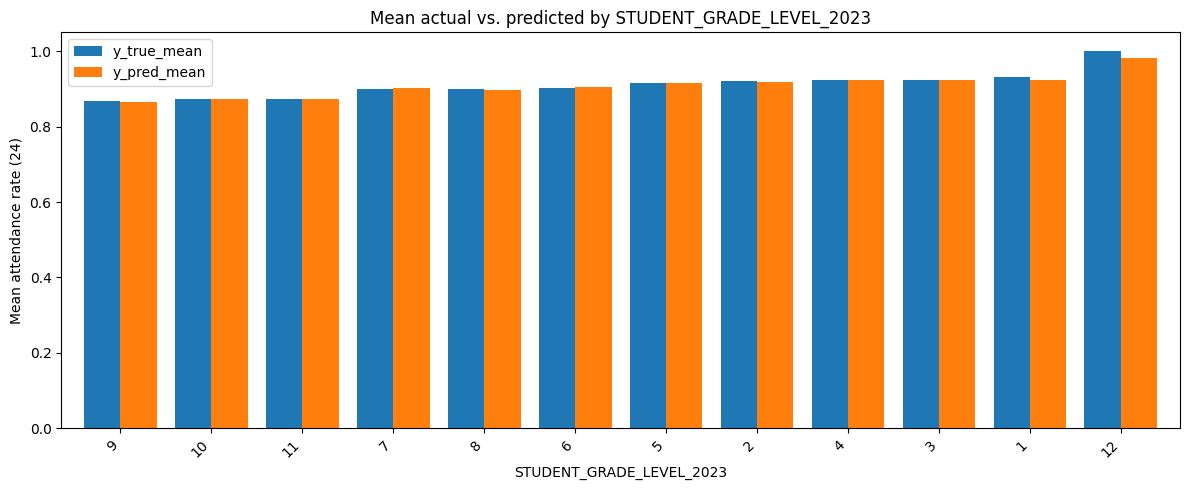

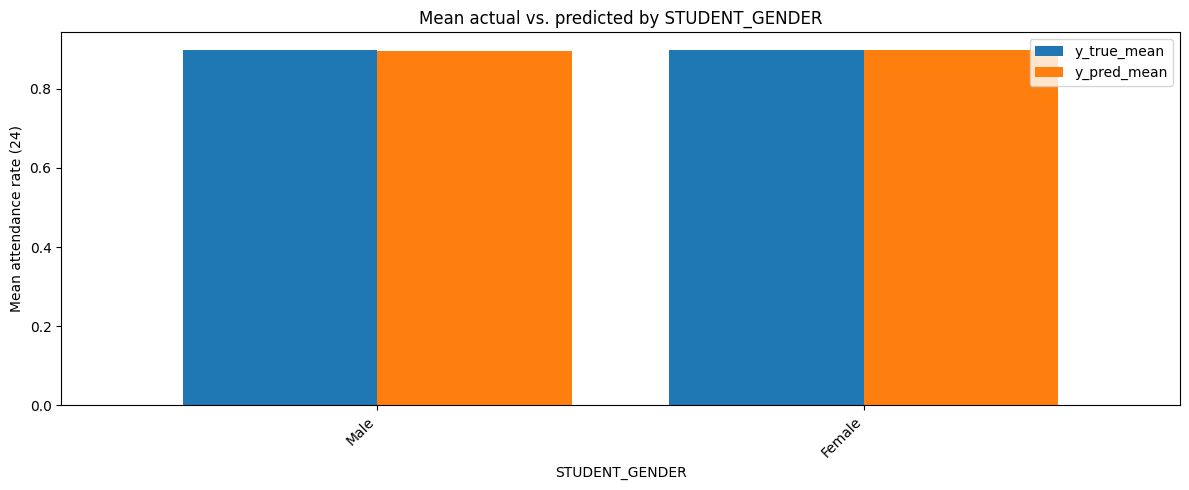

In [65]:
group_key = "STUDENT_GRADE_LEVEL_2023"

group_df = (
    df_test
    .groupby(group_key)
    .agg(y_true_mean=("y_true", "mean"),
         y_pred_mean=("y_pred", "mean"),
         count=("y_true", "size"))
    .reset_index()
    .sort_values("y_true_mean")
)

ax = group_df.plot(kind="bar", x=group_key, y=["y_true_mean", "y_pred_mean"],
                   figsize=(12, 5), width=0.8)
ax.set_ylabel("Mean attendance rate (24)")
ax.set_title("Mean actual vs. predicted by " + group_key)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

gender_key = 'STUDENT_GENDER'
gender_df = (
    df_test.groupby(gender_key)
    .agg(y_true_mean=("y_true", "mean"),
         y_pred_mean=("y_pred", "mean"),
         count=("y_true", "size"))
    .reset_index()
    .sort_values("y_true_mean")
)

ax1 = gender_df.plot(kind="bar", x=gender_key, y=["y_true_mean", "y_pred_mean"],
                   figsize=(12, 5), width=0.8)
ax1.set_ylabel("Mean attendance rate (24)")
ax1.set_title("Mean actual vs. predicted by " + gender_key)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

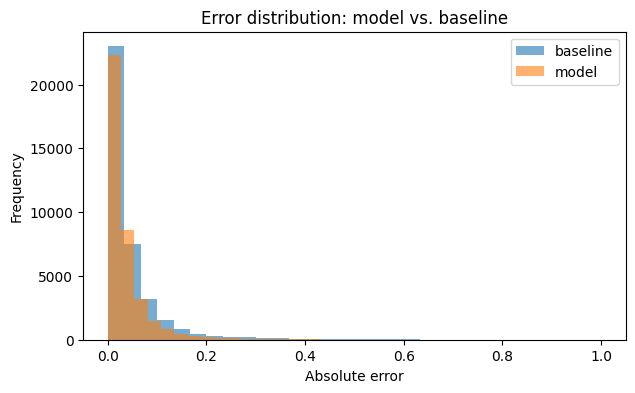

In [ ]:
from scipy import stats

df_test['y_base'] = df_test['Attendance_Rate_2023'].values
df_test["abs_err_model"] = np.abs(df_test["y_true"] - df_test["y_pred"])
df_test["abs_err_base"]  = np.abs(df_test["y_true"] - df_test["y_base"])

plt.figure(figsize=(7,4))
plt.hist(df_test["abs_err_base"],  bins=30, alpha=0.6, label="baseline")
plt.hist(df_test["abs_err_model"], bins=30, alpha=0.6, label="model")
plt.xlabel("Absolute error")
plt.ylabel("Frequency")
plt.title("Error distribution: model vs. baseline")
plt.legend()
plt.show()

In [54]:
t_stat, p_val = stats.ttest_rel(
    df_test["abs_err_base"],
    df_test["abs_err_model"],
    alternative="greater"    
)

print(f"Paired t-test:  t = {t_stat:0.2f},  p = {p_val:0.3e}")


Paired t-test:  t = 33.57,  p = 9.276e-244


In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test, check_additivity=False)


row_idx = X_test.index.get_loc(X_test.sample(1).index[0])  
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[row_idx], X_test.iloc[row_idx])
